<a href="https://colab.research.google.com/github/gatherheart/Classification_With_BERT/blob/main/bert_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<br>

# **Preparation**

In [1]:
# Hugging Face의 트랜스포머 모델을 설치
!pip install transformers

     |████████████████████████████████| 1.4MB 5.9MB/s 
     |████████████████████████████████| 890kB 41.2MB/s 
     |████████████████████████████████| 2.9MB 49.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bd04471e2dc6fc04b2d53dfd58f83538ed80bca8eae3a30f6d876f280f963ce7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BASE_PATH = '/content/drive/MyDrive/hyun_data'

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Dec  6 07:00:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

<br>
<br>

# **Data Load**

In [49]:
df = pd.read_csv(BASE_PATH+'/preprocessed_norm.csv', index_col=[0])

In [26]:
labels_csv = pd.read_csv(BASE_PATH+'/labels_dict2.csv', index_col=[0])

In [27]:
labels_csv

,문화>방송_연예,국제>중국,사회>사회일반,정치>국회_정당,사회>교육_시험,IT_과학>모바일,정치>행정_자치,사회>사건_사고,문화>문화일반,정치>청와대,사회>여성,국제>유럽_EU,경제>자원,국제>미국_북미,사회>날씨,사회>의료_건강,IT_과학>콘텐츠,경제>증권_증시,정치>선거,국제>일본,사회>미디어,문화>음악,국제>중남미,국제>중동_아프리카,경제>유통,문화>출판,경제>자동차,사회>환경,경제>금융_재테크,사회>장애인,문화>전시_공연,경제>부동산,IT_과학>IT_과학일반,문화>요리_여행,IT_과학>과학,경제>서비스_쇼핑,경제>외환,미분류,문화>미술_건축,문화>생활,경제>경제일반,국제>아시아,정치>정치일반,경제>국제경제,경제>취업_창업,IT_과학>보안,정치>외교,경제>무역,문화>영화,정치>북한,경제>산업_기업,문화>종교,경제>반도체,문화>학술_문화재,사회>노동_복지,국제>국제일반,IT_과학>인터넷_SNS,국제>러시아
0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57


In [48]:
df.columns

Index(['date', 'title', 'topic', 'keyword', 'tf-idf', 'body', 'label'], dtype='object')

In [50]:
df[df.label==0]

,date,title,topic,keyword,input,body,label
8,20201128,"'온앤오프' 이지아, '데뷔 후 최초' 베일 싸여있던 일상 공개",문화>방송_연예,"온앤오프,이지아,데뷔,베일,일상,공개,28일,방송,tvN,온앤오프,배우,이지아,반전...",이지아 온앤오프 덕후 한경닷컴 김나경 tvn 은하계 ufo 동작 하나하나 외계인설 ...,28일(토) 방송하는 tvN ’온앤오프‘에서는 배우 이지아의 반전 매력 넘치는 일상...,0
10,20201128,"'런닝맨' 김소연, '팬심' 폭발시킨 멤버 정체는?",문화>방송_연예,"런닝맨,김소연,팬심,폭발,멤버,정체,배우,김소연,팬심,고백,29일,방송,SBS,런닝...",김소연 런닝맨 팬심 이상우 멤버들 리액션 반박해 180도 다들 거짓말 펜트하우스 1...,배우 김소연이 수줍은 팬심을 고백한다.\n오는 29일 오후 방송되는 SBS ‘런닝맨...,0
15,20201128,"‘트로트의 민족’ 김소연, 우승 후보→패자부활전 합격할까[M+TV인사이드]",문화>방송_연예,"트로트,민족,김소연,우승,후보,패자부활전,합격,TV인사이드,트로트,민족,유력,우승,...",트로트 박하명 긴장감 김소연 안성준 시청률 신명근 생존자 패자부활전 장명서 나미애 ...,‘트로트의 민족’ 유력 우승 후보 김소연이 패자부활전에 나선 가운데 그의 생존에 관...,0
21,20201128,"'아는 형님' 조병규, 즉석 액션부터 성대모사까지 매력 대방출!",문화>방송_연예,"형님,조병규,즉석,액션,성대모사,매력,대방출,배우,조병규,예능,블루칩,등극,방송,J...",조병규 김세정 눈물 성대모사 유준상 친밀도 만큼 촬영장 웃픈 블루칩 자유자재 전학생...,배우 조병규가 넘치는 끼로 예능 블루칩에 등극했다.\n \n28일 방송되는 JTBC...,0
67,20201128,‘온앤오프’ 이지아 “UFO 출몰 지역을 간 적도 있다”,문화>방송_연예,"온앤오프,이지아,UFO,출몰,지역,28일,방송,tvN,온앤오프,배우,이지아,반전,매...",이지아 온앤오프 덕후 ufo tvn 동작 하나하나 은하계 외계인설 싱어송라이터 놀라...,[헤럴드경제 = 서병기 선임기자]28일(토) 밤 방송되는 tvN ’온앤오프‘에서는 ...,0
...,...,...,...,...,...,...,...
19069,20201201,영화보며 시간 여행 자연 힐링 독서하며 언택트 송년,문화>방송_연예,"영화,여행,자연,힐링,독서,언택트,송년,연말,영화,리틀,포레스트,Little,개봉,...",구멍가게 일본 순천만 미국 곽재구 루나나 해남 목포 원스 혜원 보이저 시간여행 드루...,[연말에 보면 좋은 영화]\n▲리틀 포레스트(Little Forest /감독 임순례...,0
19304,20201201,"[종합] 아이랜드 통해 데뷔한 '엔하이픈' ""7명 전원이 센터급 비주얼"" 연말 신...",문화>방송_연예,"아이랜드,데뷔,엔하이픈,전원,센터,비주얼,연말,신인상,사진,빌리프랩,제공,빅히트엔터...",엔하이픈 아이랜드 빅히트 니키 희승 제이크 제이 타이틀곡 성훈 7명 신인상 팬들 방...,[사진= 빌리프랩 제공] \n \n \n 빅히트엔터테인먼트와 Mnet의 프로젝트 ...,0
19581,20201130,"[이웃사랑] 뇌병변에 유방암까지 온 아내, 홀로 고군분투 중인 남편",문화>방송_연예,"뇌병변,유방암,아내,고군분투,남편,결혼식,뇌병변,장애,남편,4년,병간호,유방암,생활...",주희 영석 결혼식 예주 유방암 중국집 대구은행 병간호 핸드폰 일자리 생활비 매일신문...,지난 27일 달서구 감삼동의 한 주택 2층. 쿵쾅쿵쾅 계단 위로 한 여자아이가 급히...,0
19598,20201130,전효성 다이어트 “3개월만에 허리 26인치→23.5인치”,문화>방송_연예,"3개월,전효,다이어트,허리,인치,23.5인치,가수,전효,다이어트,영상,공개,화제,전...",전효성 전효 3개월 다이어터 필라테스 배달음식 필요성 유튜브 장장 2개월 식이요법 ...,가수 전효성이 다이어트 영상을 공개해 화제다.\n\n\n\n전효성이 30일 오후 자...,0


In [30]:
df[df['label']==10]

,date,title,topic,keyword,tf-idf,body,label
61,20201128,"옥천군, 여성폭력 추방 캠페인 실시",사회>여성,"옥천군,캠페인,여성,폭력,추방,캠페인,충북일보,옥천군,추방주간,여성,폭력,추방,주간...","여성폭력,성매매,성폭력,전단지,추방기간,옥천군여성단체협의회원,옥천여자중학교,옥천군,...",［충북일보］ 옥천군은 27일 '여성폭력 추방주간'을 맞아 옥천여자중학교 앞에서 옥천...,10
103,20201128,"""사지 마비된 동생, 사과 없는 가해자 엄중 처벌해달라"" 피해자 가족 호소",사회>여성,"마비,동생,사과,가해자,처벌,호소,피해자,가족,경남,진주,발생,칼치기,사고,버스,여...","가해자,청원인,피해자,청원,이종기,변호사,진주지원,공소장,고등학교,특례법,졸업식,진...",2019년 12월 경남 진주에서 발생한 '칼치기 사고'로 버스에 타고 있던 고등학교...,10
197,20201128,경남 창원 단란주점 관련 4명 진주 이통장 2명 등 13명 추가 확진,사회>여성,"단란주점,4명,경남,창원,단란주점,진주,통장,확진,추가,경남,신종,코로나바이러스,감...","확진자,50대,진주,창원,경남,사천,단란주점,60대,김해,2명,4명,접촉자,감염경로...",[아시아경제 영남취재본부 주철인 기자] 경남의 신종 코로나바이러스감염증(코로나19)...,10
320,20201128,"""뺨을 베어갈 듯"" 칼바람 막아줄 수분 신상템",사회>여성,"칼바람,수분,기온,칼바람,피부,건조,겨울철,제품,피부,장벽,케어,겨울,바람,피부,보...","저자극,마이크로바이옴,고보습,화장품,활성화,유익균,제니피끄,흡수력,비건,보습력,스킨...",[아시아경제 조유진 기자] 급격히 떨어진 기온과 칼바람으로 피부가 건조해지기 쉬운 ...,10
397,20201128,"비혼 임신, 법과 현실의 간극",사회>여성,"비혼,임신,현실,간극,사유리,방송인,후지타,비혼출산,한국사회,파장,한국,결혼,사람,...","기증자,비혼여성,비혼,생명윤리법,시험관,윤리지침,난임,인공수정,난임부부,한국,나영정...",방송인 후지타 사유리의 비혼출산은 한국사회에 적잖은 파장을 불러왔다. “한국에서는 ...,10
...,...,...,...,...,...,...,...
19191,20201201,"대한적십자사봉사회 괴산지구협의회, 희망 꾸러미 키트 나눔 펼쳐",사회>여성,"대한적십자사봉,사회,괴산지구협의회,키트,희망,꾸러미,대한적십자사봉,사회,괴산,지구,...","코로나19,괴산,괴산지구협의회,키트,김영,취약계층,10여,최준환,적십자봉사회,봉사활...",[충청투데이 김영 기자] 대한적십자사봉사회 괴산지구협의회가 연탄나눔 봉사활동에 이어...,10
19316,20201201,코로나 블루 극단적 선택 여성 급증 스마트폰 대신 햇빛 보세요,사회>여성,"코로나,블루,극단,선택,여성,급증,스마트폰,햇빛,운동,도움,우울증,예방,고위험군,정...","우울증,코로나,50대,재택근무,부산,스마트폰,사망자,생활비,관련자,정신과,좌절감,자...",- 정부 차원 고위험군 서둘러 발굴\n- 상담 제공 등 안전망 관리해야\n\n올들어...,10
19423,20201201,코로나 연말연시 모이거나 미루거나 멈추거나,사회>여성,"코로나,연말연시,풍경,도민,연말맞이,감염증,신종,코로나바이러스,코로나19,재확산,연...","코로나19,창원,파티룸,친구들,확진자,도민들,연말맞이,2단계,대유행,마산,연말연시,...",신종 코로나바이러스 감염증(코로나19)이 재확산되는 가운데 연말연시를 맞는 도민들의...,10
19537,20201201,화성시 12월부터 사회적 거리두기 단계별 일회용품 사용규제 시행,사회>여성,"화성시,사회,거리,단계,일회용품,사용,규제,시행,화성시,12월,사회,거리,사용규제,...","일회용품,다회용,사용규제,과태료,코로나19,시행령,화성시,그동안,식품접객업소,활용법...",화성시는 12월부터 사회적 거리두기 단계별 일회용품 사용규제를 시행한다고 30일 밝...,10


In [31]:
print(set(df['label']))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57}


In [32]:
NUM_LABELS = max(set(df['label'])) + 1

In [33]:
NUM_LABELS

58

In [34]:
text_to_label = dict(labels_csv)

In [35]:
int(text_to_label['IT_과학>IT_과학일반'])

32

In [36]:
label_to_text = {}
for label in text_to_label:
    label_to_text[int(text_to_label[label])] = label

In [37]:
label_to_text

{0: '문화>방송_연예',
 1: '국제>중국',
 2: '사회>사회일반',
 3: '정치>국회_정당',
 4: '사회>교육_시험',
 5: 'IT_과학>모바일',
 6: '정치>행정_자치',
 7: '사회>사건_사고',
 8: '문화>문화일반',
 9: '정치>청와대',
 10: '사회>여성',
 11: '국제>유럽_EU',
 12: '경제>자원',
 13: '국제>미국_북미',
 14: '사회>날씨',
 15: '사회>의료_건강',
 16: 'IT_과학>콘텐츠',
 17: '경제>증권_증시',
 18: '정치>선거',
 19: '국제>일본',
 20: '사회>미디어',
 21: '문화>음악',
 22: '국제>중남미',
 23: '국제>중동_아프리카',
 24: '경제>유통',
 25: '문화>출판',
 26: '경제>자동차',
 27: '사회>환경',
 28: '경제>금융_재테크',
 29: '사회>장애인',
 30: '문화>전시_공연',
 31: '경제>부동산',
 32: 'IT_과학>IT_과학일반',
 33: '문화>요리_여행',
 34: 'IT_과학>과학',
 35: '경제>서비스_쇼핑',
 36: '경제>외환',
 37: '미분류',
 38: '문화>미술_건축',
 39: '문화>생활',
 40: '경제>경제일반',
 41: '국제>아시아',
 42: '정치>정치일반',
 43: '경제>국제경제',
 44: '경제>취업_창업',
 45: 'IT_과학>보안',
 46: '정치>외교',
 47: '경제>무역',
 48: '문화>영화',
 49: '정치>북한',
 50: '경제>산업_기업',
 51: '문화>종교',
 52: '경제>반도체',
 53: '문화>학술_문화재',
 54: '사회>노동_복지',
 55: '국제>국제일반',
 56: 'IT_과학>인터넷_SNS',
 57: '국제>러시아'}

In [52]:
df = df.rename(columns={'특성추출(가중치순 상위 50개)':'input'})

In [53]:
train, test = train, test = train_test_split(df, test_size=0.2)

print(train.shape)
print(test.shape)

(38783, 7)
(9696, 7)


In [54]:
# 훈련셋의 앞부분 출력
train.head(10)

,date,title,topic,keyword,input,body,label
4370,20201204,수능 시험 뒤 고3 수험생 등 학교 방역은?,사회>교육_시험,"수능,시험,수험,학교,방역,앵커,전북,2천,학년도,대입수학능력시험,순조,교육당국,수...",수험생 전북교육청 감독관 코로나19 고사장 오중호 노래방 영화관 촬영기자 다중이용시...,[KBS 전주]\n [앵커]\n\n오늘 전북에서도 2천21학년도 대입수학능력시험이 ...,4
11312,20201120,"한국능률협회컨설팅, ‘2021사업계획수립’ 결정지을 온라인 강의 론칭",경제>경제일반,"한국능률협회컨설팅,2021사업,계획수립,론칭,온라인,강의,한국능률협회컨설팅,KMAC...",실리콘밸리 온라인 미국 론칭 부회장 김종립 한국능률협회컨설팅 kmac 문의전화 홈페...,"한국능률협회컨설팅(이하 KMAC, 대표이사 부회장 김종립)이 미국 실리콘밸리 혁신기...",40
480,20201128,[속보] 코로나19 사망자 어제 6명 늘어 총 522명,국제>아시아,"코로나19,사망자,522명,속보,코로나19,코로나19,사망자,522명",코로나19 사망자 속보,[속보] 코로나19 어제 사망자 6명 늘어 총 522명 (끝) \n \n oh@he...,41
6039,20201121,"[코로나19] 일본, 사상 최초 일일 확진자 2560명...도쿄서만 539명 나와",국제>일본,"일본,사상,2560명,일일,확진자,도쿄서,539명,고투,트래블,Travel,불가피,...",일본 확진자 코로나19 이트 나흘 행인들 사망자 긴자 번화가 횡단보도 도쿄도 nhk...,일본 도쿄의 번화가인 긴자 거리에서 마스크를 쓴 행인들이 횡단보도를 건너는 모습. ...,19
15386,20201201,OECD “한국 올해 성장률 -1.1% 회원국 중 최소 하락”,경제>국제경제,"OECD,한국,성장,1.1%,회원국,최소,하락,경제협력개발기구,OECD,전망치,한국...",오이시디 회원국 한국 코로나19 성장률 로렌스 중국 연평균 전망치 하향조정 서비스업...,경제협력개발기구(OECD)가 올해 한국 경제성장률 전망치를 지난 9월 -1.0%에서...,43
4009,20201127,"[속보] 어제 569명 확진, 이틀 연속 500명대",사회>사회일반,"확진,500명대,이틀,연속,명대,26일,신규,코로나,확진자,569명,집계,중앙방역대...",확진자 var 2단계 중앙재난안전대책본부 수도권 서울 인천 코로나19 일주일 코로나...,어제(26일) 국내 신규 코로나 확진자는 569명으로 집계됐다. 중앙방역대책본부는 ...,2
7052,20201127,"文대통령 ""수소차 등 미래차, 탄소중립 선도산업으로 육성""",정치>청와대,"대통령,수소차,미래차,탄소,중립,선도,산업,육성,문재인,대통령,청와대,2050탄소,...",미래차 저탄소 수소차 청와대 일자리 기술혁신 충전소 제조업 2050탄소 민간기업 산...,[머니투데이 정진우 기자] [[the300]]\n\n \n\n\n문재인 대통령이 2...,9
10796,20201120,서울시교육청 “내일 중등 임용시험 예정대로 실시 확진자 응시 불가”,사회>교육_시험,"서울시교육청,불가,확진자,응시,노량진,교사,임용,시험,학원,코로나19,집단,감염,발...",서울 임용시험 코로나19 확진자 노량진 교육청 시험실 관계자 선정경쟁시험 자가격리자...,노량진 교사 임용시험 학원에서 코로나19 집단감염이 발생한 것과 관련해 교육당국은 ...,4
10394,20191128,[자막뉴스] '한국에 양보' 비난 피하려고? 또 억지 주장 펴는 일본,국제>일본,"한국,양보,비난,억지,주장,일본,22일,청와대,지소미아,조건부,종료,연기,5분,일본...",일본 지소미아 한국 요이치 관리부장 그간 사이토 청와대 외무상 조건부 자막뉴스 영상...,지난 22일 오후 6시 청와대가 지소미아 조건부 종료 연기를 발표하자 5분쯤 뒤 일...,19
5052,20201122,(속보) 익산 또 추가 확진 3명... 닷새간 31명,사회>사회일반,"속보,익산,3명,추가,확진,닷새,익산지역,3명,코로나19,확진자,추가,발생,전북18...",익산 3명 닷새간 확진자 익산시 전북181번 전북 원광대병원 익산21번 간호사 원광...,익산지역에서 또다시 3명의 코로나19 확진자가 추가 발생했다. \n\n전북181번(...,2


<br>
<br>

# **Preprocessing - TRAINING SET**

In [55]:
# 리뷰 문장 추출
sentences = train['input']
sentences[:10]

4370     수험생 전북교육청 감독관 코로나19 고사장 오중호 노래방 영화관 촬영기자 다중이용시...
11312    실리콘밸리 온라인 미국 론칭 부회장 김종립 한국능률협회컨설팅 kmac 문의전화 홈페...
480                                           코로나19 사망자 속보
6039     일본 확진자 코로나19 이트 나흘 행인들 사망자 긴자 번화가 횡단보도 도쿄도 nhk...
15386    오이시디 회원국 한국 코로나19 성장률 로렌스 중국 연평균 전망치 하향조정 서비스업...
4009     확진자 var 2단계 중앙재난안전대책본부 수도권 서울 인천 코로나19 일주일 코로나...
7052     미래차 저탄소 수소차 청와대 일자리 기술혁신 충전소 제조업 2050탄소 민간기업 산...
10796    서울 임용시험 코로나19 확진자 노량진 교육청 시험실 관계자 선정경쟁시험 자가격리자...
10394    일본 지소미아 한국 요이치 관리부장 그간 사이토 청와대 외무상 조건부 자막뉴스 영상...
5052     익산 3명 닷새간 확진자 익산시 전북181번 전북 원광대병원 익산21번 간호사 원광...
Name: input, dtype: object

In [56]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 수험생 전북교육청 감독관 코로나19 고사장 오중호 노래방 영화관 촬영기자 다중이용시설 가림막 고등학교 2천 학부모 학년도 전북 대입수학능력시험 유튜브 시험장 지자체 안전사고 정영수 설명회 김진호 교육당국 함산 시험실 [SEP]',
 '[CLS] 실리콘밸리 온라인 미국 론칭 부회장 김종립 한국능률협회컨설팅 kmac 문의전화 홈페이지 한국능률협회 트랜스포메이션 소비재 거시적 2021사업 소매업 100여 리테일 계획수립 [SEP]',
 '[CLS] 코로나19 사망자 속보 [SEP]',
 '[CLS] 일본 확진자 코로나19 이트 나흘 행인들 사망자 긴자 번화가 횡단보도 도쿄도 nhk 매입가격 전문가 상품권 광역자치단체 [SEP]',
 '[CLS] 오이시디 회원국 한국 코로나19 성장률 로렌스 중국 연평균 전망치 하향조정 서비스업 반도체 비정규직 재확산 경제학자 경제활동 oecd 일자리 미국 20개국 전환점 경제전망 [SEP]',
 '[CLS] 확진자 var 2단계 중앙재난안전대책본부 수도권 서울 인천 코로나19 일주일 코로나 script document id dist js https 대유행 판가름 전문가 정세균 [SEP]',
 '[CLS] 미래차 저탄소 수소차 청와대 일자리 기술혁신 충전소 제조업 2050탄소 민간기업 산업생태계 기관차 문재인 전기차 산업 전환 지원 대통령 중심 노력 탄소 중립 육성 집중 전략 회의 확대 기업 관심 주재 보급 민간 혁신 확충 각별 생산 총력 대대적 [SEP]',
 '[CLS] 서울 임용시험 코로나19 확진자 노량진 교육청 시험실 관계자 선정경쟁시험 자가격리자 서울시교육청 지원자 신청서 집단감염 동작구 200여명 [SEP]',
 '[CLS] 일본 지소미아 한국 요이치 관리부장 그간 사이토 청와대 외무상 조건부 자막뉴스 영상편집 황보연 기자들 취재기자 미국 아베 삼척동자 가지야마 모테기 도쿄 [SEP]',
 '[CLS] 익산 3명 닷새간 확진자 익산시 전북181번 전북 원광대병원 익산21번 간호사 원광대학교병원 익산지역 1명

In [57]:
# 라벨 추출
labels = train['label'].values
labels

array([ 4, 40, 41, ..., 49, 13, 20])

In [58]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])


[CLS] 수험생 전북교육청 감독관 코로나19 고사장 오중호 노래방 영화관 촬영기자 다중이용시설 가림막 고등학교 2천 학부모 학년도 전북 대입수학능력시험 유튜브 시험장 지자체 안전사고 정영수 설명회 김진호 교육당국 함산 시험실 [SEP]
['[CLS]', '수', '##험', '##생', '전', '##북', '##교', '##육', '##청', '감독', '##관', '코', '##로', '##나', '##19', '고', '##사', '##장', '오', '##중', '##호', '노래', '##방', '영화', '##관', '촬', '##영', '##기', '##자', '다', '##중', '##이', '##용', '##시', '##설', '가', '##림', '##막', '고', '##등학교', '2', '##천', '학', '##부', '##모', '학', '##년', '##도', '전', '##북', '대', '##입', '##수', '##학', '##능', '##력', '##시', '##험', '유', '##튜', '##브', '시', '##험', '##장', '지', '##자', '##체', '안', '##전', '##사', '##고', '정', '##영', '##수', '설', '##명', '##회', '김', '##진', '##호', '교', '##육', '##당', '##국', '함', '##산', '시', '##험', '##실', '[SEP]']


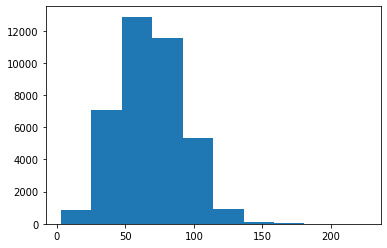

In [59]:
import matplotlib.pyplot as plt
plt.hist(list(map(len, tokenized_texts)))
plt.show()

In [60]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9460,  86834,  24017,   9665,  82512,  25242,  83811,
        40311,  81571,  20595,   9812,  11261,  16439,  54055,   8888,
        12945,  13890,   9580,  41693,  20309,  99706,  42337,  42428,
        20595,   9763,  30858,  12310,  13764,   9056,  41693,  10739,
        24974,  14040,  31928,   8843,  67527, 118907,   8888,  55511,
          123,  38631,   9953,  14646,  39420,   9953,  10954,  12092,
         9665,  82512,   9069,  58303,  15891,  23321,  74986,  28143,
        14040,  86834,   9625, 119368,  52015,   9485,  86834,  13890,
         9706,  13764,  29683,   9521,  16617,  12945,  11664,   9670,
        30858,  15891,   9429,  16758,  14863,   8935,  18623,  20309,
         8907,  83811,  21928,  20479,   9956,  21386,   9485,  86834,
        31503,    102,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [61]:
print(tokenizer.convert_ids_to_tokens(input_ids[0]))

['[CLS]', '수', '##험', '##생', '전', '##북', '##교', '##육', '##청', '감독', '##관', '코', '##로', '##나', '##19', '고', '##사', '##장', '오', '##중', '##호', '노래', '##방', '영화', '##관', '촬', '##영', '##기', '##자', '다', '##중', '##이', '##용', '##시', '##설', '가', '##림', '##막', '고', '##등학교', '2', '##천', '학', '##부', '##모', '학', '##년', '##도', '전', '##북', '대', '##입', '##수', '##학', '##능', '##력', '##시', '##험', '유', '##튜', '##브', '시', '##험', '##장', '지', '##자', '##체', '안', '##전', '##사', '##고', '정', '##영', '##수', '설', '##명', '##회', '김', '##진', '##호', '교', '##육', '##당', '##국', '함', '##산', '시', '##험', '##실', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [62]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [63]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2020, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2020,
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   8903,  16323,   9994,  18623,  13764,   9022,  44321,  18623,
          9812,  11261,  16439,  54055,  48253,   8900,  21611,  13764,   9644,
         24974,  11664,  14040,   9460,  86834,  24017,   8907,  83811,  14646,
          9644,  24974,  14040,  86834,   9460,  47181,  24017,    122,  16758,
          9751,  12638,  14423,   9989, 119391,  44359,   9639,  21386,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [64]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

<br>
<br>

# **Preprocessing - TEST SET**

In [65]:
# 리뷰 문장 추출
sentences = test['input']
sentences[:10]

18542    rcep 중소기업 fta 인지도 중기중앙회 경쟁력 지원정책 온라인 일본 김태환 전시...
9971     병원장 서울아산병원장 박성욱 남기호 박승일 아산의료원장 정몽준 아산 이사장 아산사회...
18031    합창단 동아시아 인천 합창제 중국 한국 인천시 외국인 코로나19 국제합창제 서구문화...
732      생활관리사 간담회 관리사 독거노인 소하노인종합복지관 광명시 박승원 병원동 병원동행 ...
4791     최수종 커플룩 인스타 해시태그 최윤서씨 누리꾼 다정 인스타그램 최윤서 뒷모습 시간들...
16790    학생들 임성호 고사장 코로나19 재수생 가림막 난이도 ytn 순발력 코로나바이러스 ...
2640     생존자 자살생존자 한국 자살자 유가족 외도 사람들 상처들 황웃는돌씨 통계청 황웃는돌...
4658     민원인 공직자 박성일 완주 서원대학교 완주군 정태연 친절도 서비스학 체감친절도 주민...
8959     온젠티스 파킨슨병 치료제 레보도파 유럽 비알 파킨슨 김정훈 중추신경계 동작 운동동요...
11351     서울 동작구 학년도 숭실대학교 고사장 시험 논술 신분 대학 수학 수험 능력 확인 마스크
Name: input, dtype: object

In [66]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] rcep 중소기업 fta 인지도 중기중앙회 경쟁력 지원정책 온라인 일본 김태환 전시회 활용방안 정작 [SEP]',
 '[CLS] 병원장 서울아산병원장 박성욱 남기호 박승일 아산의료원장 정몽준 아산 이사장 아산사회복지재단 홍천아산병원장 홍천아산 부원장 박성욱씨 서울아산 진료 임명 원장 임기 의료 사진 부장 [SEP]',
 '[CLS] 합창단 동아시아 인천 합창제 중국 한국 인천시 외국인 코로나19 국제합창제 서구문화회관 인천서구문화회관 동아시아인 대사관 경기일보 음대교수 베트남 인천관광공사 입상팀 전통악기 협회장 합창지휘자 필리핀 자신들 관계자 협회장상 전통민요 전통의상 관광부 음악성 자부심 자유곡 주한중국문화원 일본 [SEP]',
 '[CLS] 생활관리사 간담회 관리사 독거노인 소하노인종합복지관 광명시 박승원 병원동 병원동행 말벗서비스 어르신들 주년 일상생활 시장님 안부확인 말벗 만65세 광명 기본서비스 고독사 1천 생활관리들 생활관리사들 노인돌 시간date 노인맞춤 서비스 노인 생활 지원 시장 확대 [SEP]',
 '[CLS] 최수종 커플룩 인스타 해시태그 최윤서씨 누리꾼 다정 인스타그램 최윤서 뒷모습 시간들 하희라 sns 모습 산책 결혼 자신 감사 가을 시간 그램 사랑 통로 누리 공개 슬하 부녀 분위기 아빠 축복 팔짱 연인 사진 영상 반응 게재 일상 공유 [SEP]',
 '[CLS] 학생들 임성호 고사장 코로나19 재수생 가림막 난이도 ytn 순발력 코로나바이러스 종로학원 대표이사 코로나 수준대 변별력 결시자 전문가 집중도 감염증 물수능 [SEP]',
 '[CLS] 생존자 자살생존자 한국 자살자 유가족 외도 사람들 상처들 황웃는돌씨 통계청 황웃는돌 별자 지지모임 자살사 사망자 자살사별자 교통사고 죄책감 얘깁 결혼식 경제협력개발국가 자살율 특성화 20여년 미국 5배 연예인 친숙 조금씩 38만 자살예방재단 5명 금기시 정치인 9명 한다리 한국사회 72만 자살생존 웹툰 그중 자살유족 survivor weekpick [SEP]',
 '[CLS] 민원

In [67]:
# 라벨 추출
labels = test['label'].values
labels

array([47, 10, 21, ...,  4,  3,  0])

In [68]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] rcep 중소기업 fta 인지도 중기중앙회 경쟁력 지원정책 온라인 일본 김태환 전시회 활용방안 정작 [SEP]
['[CLS]', 'r', '##ce', '##p', '중', '##소', '##기', '##업', 'ft', '##a', '인', '##지', '##도', '중', '##기', '##중', '##앙', '##회', '경', '##쟁', '##력', '지', '##원', '##정', '##책', '온', '##라', '##인', '일본', '김', '##태', '##환', '전', '##시', '##회', '활', '##용', '##방', '##안', '정', '##작', '[SEP]']


In [69]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,    186,  10419,  10410,   9694,  22333,  12310,  26784,
        13786,  10113,   9640,  12508,  12092,   9694,  12310,  41693,
       119119,  14863,   8885, 119202,  28143,   9706,  14279,  16605,
       119254,   9582,  17342,  12030,  23130,   8935,  83616,  51745,
         9665,  14040,  14863,   9996,  24974,  42337,  34951,   9670,
        38709,    102,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [70]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [71]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   101,    186,  10419,  10410,   9694,  22333,  12310,  26784,  13786,
         10113,   9640,  12508,  12092,   9694,  12310,  41693, 119119,  14863,
          8885, 119202,  28143,   9706,  14279,  16605, 119254,   9582,  17342,
         12030,  23130,   8935,  83616,  51745,   9665,  14040,  14863,   9996,
         24974,  42337,  34951,   9670,  38709,    102,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [72]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

<br>
<br>

# **MODEL Initialization**

In [73]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [74]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [75]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=NUM_LABELS)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [76]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 30

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

<br>
<br>

# **MODEL Training**

In [77]:
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [78]:
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [79]:
from time import gmtime, strftime
START_TIME = strftime("%Y_%m_%d_%H_%M_%S", gmtime())

In [80]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    PATH = BASE_PATH+"/bert_news_model_{}.pth".format(START_TIME)
    torch.save(model.state_dict(), PATH)
    print("  Model saved at {}".format(PATH))
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 30 ========
Training...


KeyboardInterrupt: ignored

#**Load Model**

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=NUM_LABELS)
model.cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

<br>
<br>

# **Test Set Evaluation**

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of    375.    Elapsed: 0:00:07.
  Batch   200  of    375.    Elapsed: 0:00:13.
  Batch   300  of    375.    Elapsed: 0:00:20.

Accuracy: 0.58
Test took: 0:00:25


<br>
<br>

# **NEW topic Test**

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
logits = test_sentences(['경찰 무력 시위 강압 폭행'])

print(logits)
print(np.argmax(logits))


[[-0.5553014   1.1636798   4.331775    0.284531    0.701762    0.18182372
  -0.81259525 -0.6040593   0.73273855 -0.07076877  0.05800076  1.6265992
  -0.6516759  -0.79124063  1.6689017  -1.013213    1.4717002  -0.16425364
  -0.93220574 -0.31989643  1.8041921  -0.4293834  -1.014419   -1.1526823
  -0.63746774 -1.6706144  -0.03637895  0.14784603  0.76720166 -0.43307778
  -0.7251667  -0.48204148 -0.2615093  -0.17751452 -0.7837909  -0.83278006
  -1.6937932  -0.64513594 -0.4853816   3.1254256  -0.17023526 -0.5775923
   0.06924354  0.65088516 -0.319876   -0.8639546   0.2839826  -0.2693283
   0.29786462 -1.0309901  -0.38604105 -0.8095653   0.3269498  -0.04358091
  -0.6004411  -0.7257758   0.9699153   0.66252625 -0.15584436  0.01081265
  -0.44517967 -0.8007265   0.24600221 -1.0492593   0.28927797 -0.32362634
  -0.60572743 -0.59088296 -0.97560203 -0.21741377 -0.13653731 -1.0215555
  -0.14815433 -1.2362684  -0.47499362 -0.8426772   0.5446229   0.16645676
  -0.9795745  -0.68315876 -0.6824562  -0.53